In [2]:
import gensim
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance, euclidean_distance
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from gensim.summarization import keywords
from gensim.summarization import summarize
import pickle

model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
#https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download

In [3]:
from summarization import Summarizer
import pickle

summarizer = Summarizer("sample3")
sums = summarizer.summarize_all()
files = summarizer.files 

for sum in sums:
    print(len(sum))

corpus = []
d = dict()

i = 0
for sum in sums:
    for x in sum:
        corpus.append(x)
        d[x] = i
        i+=1
        
print(len(corpus))
pickle.dump(corpus, open("corpus.p", "wb" ))

10
20
14
15
6
13
13
13
9
113


In [4]:
corpus = pickle.load(open("corpus.p", "rb" ) )

data = []
for sentence in corpus:
    sentence = sentence.lower().split()
    #res = []
    res = 0
    n = 0
    for word in sentence:
        try:
            res+=model[word]
            #res.append(model[word])
            n+=1
        except:
            pass
    res/=n
    #print(n)
    #for i in range(50-n):
    #    res.append([0]*300)
    res = np.array(res)
    #print(res.shape)
    data.append(res.reshape(-1))
    
data = np.array(data)
pickle.dump(data, open( "data.p", "wb" ) )

But there are people who pretend to be patriot but do anything for their own interest even at the cost of their native country.


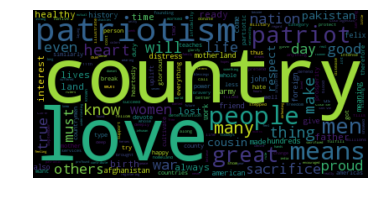

We must not have the perverted notion of patriotism that believes in the dictum : “My country, right or wrong.” Most of the crimes against humanity have been committed by people having this type of fanatic patriotism.


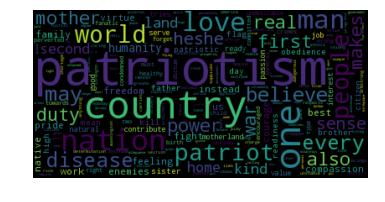

One who is a true patriot is ready to sacrifice his all for his native country.


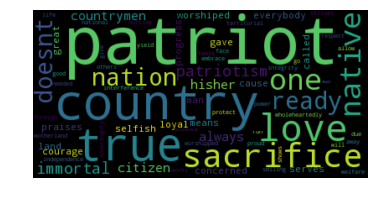

In [5]:
data = pickle.load(open("data.p", "rb" ) )
NUM_CLUSTERS = 3

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=euclidean_distance, repeats=100) #euclidean_distance #cosine_distance
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)
#print(kclusterer.means())

import re
from collections import Counter
for j in range(NUM_CLUSTERS):
    cluster = [corpus[i] for i in range(len(corpus)) if assigned_clusters[i]==j]

    text = []
    for i in range(len(cluster)):
        sentense = str(cluster[i]).lower().split(" ")
        for word in sentense:
            text.append(re.sub(r'[^\w\s]','',str(word)))
    cnt = Counter(text)
    f = open("cluster_"+str(j)+".txt", 'w')
    for item in text:
        f.write("%s\n" % item)
    f.close()
    
    text = open("cluster_"+str(j)+".txt").read()
    wordcloud = WordCloud().generate(text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    m = 100
    l = 0
    for k in range(len(data)):
        t = euclidean_distance(data[k], kclusterer.means()[j])
        if t<m:
            m=t
            l=k
    print(corpus[l])
    plt.show()

In [6]:
weights = [0.5,-0.1, 0.3, ]

In [7]:
i = 0
for essay in sums:
    res = 0
    for sentance in essay:
        k = assigned_clusters[d[sentance]]
        #print(k)
        res+= weights[k]
    print(files[i], round(res,1))
    i+=1

03-Essay01 2.4
03-Essay02 6.4
03-Essay03 2.0
03-Essay04 2.3
03-Essay05 1.2
03-Essay06 2.5
03-Essay07 1.9
03-Essay08 1.5
03-Essay09 4.5
